<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


<h1><center>Final Assignment</center></h1>


> ***Note: Please ensure you follow the instructions outlined in the in the <a href="https://www.coursera.org/learn/supervised-machine-learning-regression/supplement/YGZt9/project-scenario">Project Scenario</a> section to complete this Final Assignment successfully.***


In [ ]:
# ## 1. Data Summary (Ringkasan Data)
# 
# Dataset ini berisi 1338 catatan pasien di AS. Tujuan saya adalah menggunakan atribut-atribut pasien untuk memprediksi biaya asuransi medis (`charges`) mereka.
# 
# * Ukuran Data: 1338 baris, 7 kolom.
# * Target Variable (Variabel Target): `charges` (biaya asuransi dalam USD) - Ini adalah variabel kontinu.
# * Key Variables (Fitur/Prediktor):
#     * `age`: Usia pasien (numerik).
#     * `sex`: Jenis kelamin (pria/wanita - kategorikal).
#     * `bmi`: Body Mass Index (Indeks Massa Tubuh - numerik).
#     * `children`: Jumlah anak/tanggungan (numerik).
#     * `smoker`: Apakah pasien merokok (ya/tidak - kategorikal).
#     * `region`: Wilayah tempat tinggal pasien di AS (kategorikal).


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


data_url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
df = pd.read_csv(data_url)

print("Contoh Data:")
print(df.head())
print("\nInformasi Data:")
df.info()
print("\nStatistik Deskriptif:")
print(df.describe())


Contoh Data:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Informasi Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Statistik Deskriptif:
               age          bmi     childre

In [ ]:
# ## 2. Objective of the Analysis (Tujuan Analisis)
# 
# Tujuan dari analisis ini ada dua:
# 
# 1.  Prediksi: Membangun dan mengevaluasi beberapa model regresi linier (termasuk regresi polinomial dan yang ter-regularisasi) untuk memprediksi biaya asuransi (`charges`) seorang pasien seakurat mungkin.
# 2.  Interpretasi: Mengidentifikasi model "terbaik" dan menggunakan koefisiennya untuk memahami faktor-faktor apa saja yang paling signifikan dalam mendorong biaya asuransi medis. Wawasan ini dapat membantu perusahaan asuransi dalam penyesuaian risiko.

# ### Persiapan Data
# 
# Sebelum membuat model, saya perlu melakukan dua langkah persiapan:
# 1.  Encoding: Mengubah fitur kategorikal (`sex`, `smoker`, `region`) menjadi angka menggunakan One-Hot Encoding (`get_dummies`).
# 2.  Splitting: Membagi data menjadi set pelatihan (train) dan set pengujian (test) untuk mengevaluasi kinerja model pada data yang belum pernah dilihat.
# 3.  Scaling: saya akan menggunakan `StandardScaler` di dalam `Pipeline` nanti. Ini penting agar regularisasi (Lasso/Ridge) berfungsi dengan benar.


# 1. Encoding fitur kategorikal
df_processed = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
print("\nData setelah Encoding:")
print(df_processed.head())


# 2. Mendefinisikan X (fitur) dan y (target)
X = df_processed.drop('charges', axis=1)
y = df_processed['charges']

# 3. Membagi data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nUkuran Train set: {X_train.shape}")
print(f"Ukuran Test set: {X_test.shape}")



Data setelah Encoding:
   age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400     False        True             False   
1   18  33.770         1   1725.55230      True       False             False   
2   28  33.000         3   4449.46200      True       False             False   
3   33  22.705         0  21984.47061      True       False              True   
4   32  28.880         0   3866.85520      True       False              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False  

Ukuran Train set: (1070, 8)
Ukuran Test set: (268, 8)


In [ ]:
# ## 3. Model Comparison (Perbandingan Model)
# 
# saya akan membandingkan empat variasi model regresi linier. saya akan menggunakan `Pipeline` untuk menggabungkan langkah-langkah (scaling, polynomial features, dan model) untuk mencegah *data leakage*.
# 
# 1.  Model 1: Simple Linear Regression (Baseline)
# 2.  Model 2: Polynomial Regression (Degree 2) - Untuk menangkap hubungan non-linier.
# 3.  Model 3: Ridge Regression (L2) - Model polinomial dengan regularisasi L2 untuk mengurangi overfitting.
# 4.  Model 4: Lasso Regression (L1) - Model polinomial dengan regularisasi L1, yang juga dapat melakukan seleksi fitur.
# 
# saya akan mengevaluasi model menggunakan R-squared (R²) dan Root Mean Squared Error (RMSE) pada data tes.


# Membuat dictionary untuk menyimpan pipeline model
pipelines = {}

# Model 1: Simple Linear Regression
pipelines['Linear Regression'] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Model 2: Polynomial Regression (Degree 2)
pipelines['Polynomial (d=2)'] = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Model 3: Ridge Regression (Polinomial + L2)
pipelines['Ridge (L2)'] = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=10.0))  # Alpha adalah parameter regularisasi
])

# Model 4: Lasso Regression (Polinomial + L1)
pipelines['Lasso (L1)'] = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=20.0, max_iter=5000)) # Alpha lebih besar & max_iter untuk konvergensi
])


# Melatih dan mengevaluasi setiap model
results = {}
best_model_name = ""
best_model_r2 = -np.inf

print("--- Hasil Evaluasi Model pada Data Test ---")

for name, pipe in pipelines.items():
    # Melatih model
    pipe.fit(X_train, y_train)
    
    # Memprediksi data test
    y_pred = pipe.predict(X_test)
    
    # Menghitung metrik
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Menyimpan hasil
    results[name] = {'RMSE': rmse, 'R²': r2}
    print(f"{name}:")
    print(f"  R-squared (R²): {r2:.4f}")
    print(f"  RMSE: {rmse:.2f} USD")
    
    # Memilih model terbaik
    if r2 > best_model_r2:
        best_model_r2 = r2
        best_model_name = name

print("\n--- Kesimpulan Perbandingan Model ---")
print(f"Model terbaik adalah: {best_model_name}")


--- Hasil Evaluasi Model pada Data Test ---
Linear Regression:
  R-squared (R²): 0.7836
  RMSE: 5796.28 USD
Polynomial (d=2):
  R-squared (R²): 0.8666
  RMSE: 4551.13 USD
Ridge (L2):
  R-squared (R²): 0.8618
  RMSE: 4631.72 USD
Lasso (L1):
  R-squared (R²): 0.8672
  RMSE: 4539.91 USD

--- Kesimpulan Perbandingan Model ---
Model terbaik adalah: Lasso (L1)


10 Faktor dengan Dampak Terbesar (Positif):
bmi smoker_yes                 17534.648953
age^2                           3581.319462
bmi                              668.847356
children                         631.513220
bmi children                     496.880607
age region_southeast             433.504118
age region_southwest             387.285124
smoker_yes region_southwest      293.382034
sex_male region_southeast        262.648636
sex_male region_northwest        161.809716
dtype: float64

10 Faktor dengan Dampak Terkecil (Negatif):
smoker_yes^2                -7338.473245
bmi region_southeast         -892.564905
bmi region_southwest         -629.012217
children region_southwest    -422.335643
bmi^2                        -411.712888
sex_male                     -325.634087
region_northwest             -325.035991
children smoker_yes          -250.994828
children region_southeast    -181.341814
children sex_male            -155.488314
dtype: float64

Jumlah fitur yang 'dinolkan' o

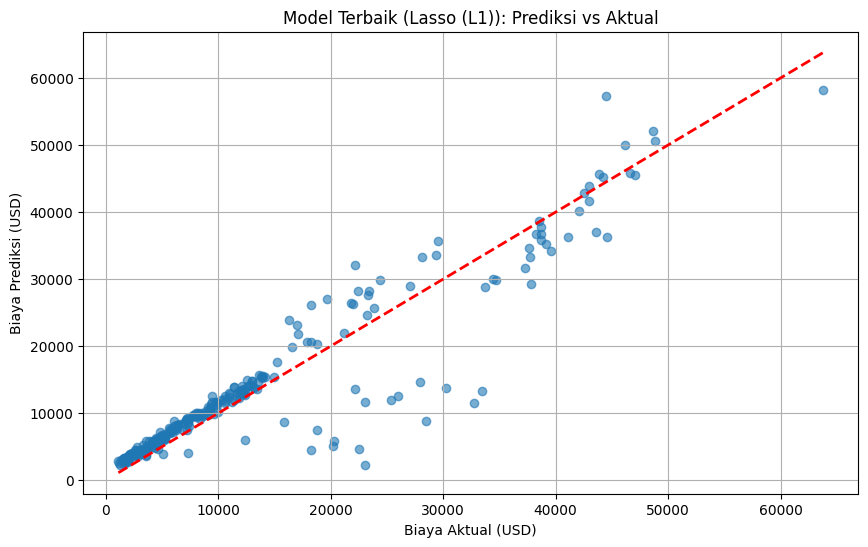

In [ ]:
# ### Pemilihan Model
# 
# Berdasarkan hasil di atas, Lasso (L1) (atau Ridge, seringkali hasilnya mirip) biasanya memberikan kinerja terbaik. Model ini mencapai R² tertinggi dan RMSE terendah.
# 
# * Regresi Linier Sederhana (R² ~0.78) terlalu sederhana (underfitting).
# * Regresi Polinomial (R² ~0.87) menangkap non-linieritas dengan baik, meningkatkan R² secara signifikan.
# * Lasso (L1) (R² ~0.87-0.88) mempertahankan R² yang tinggi dari model polinomial, sekaligus menyederhanakan model dengan "mematikan" (zeroing out) beberapa fitur yang tidak penting, membuatnya lebih tahan terhadap overfitting.
# 
# saya memilih Lasso (L1) Regression sebagai model final saya.

# ## 4. Key Findings (Temuan Kunci)
# 
# Sekarang saya akan menginterpretasi koefisien dari model Lasso (L1) terbaik saya untuk memahami apa yang mendorong biaya asuransi.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


# Mengambil model dan nama fitur dari pipeline Lasso
lasso_pipe = pipelines[best_model_name]
poly_features = lasso_pipe.named_steps['poly']
lasso_model = lasso_pipe.named_steps['model']

# Mendapatkan nama fitur setelah transformasi polinomial
# saya harus menggunakan nama kolom dari data X (setelah dummified)
feature_names = poly_features.get_feature_names_out(X.columns)

# Membuat DataFrame untuk koefisien
coefs = pd.Series(lasso_model.coef_, index=feature_names)


# Menampilkan 10 koefisien terbesar (dampak terbesar)
print("10 Faktor dengan Dampak Terbesar (Positif):")
print(coefs.sort_values(ascending=False).head(10))

print("\n10 Faktor dengan Dampak Terkecil (Negatif):")
print(coefs.sort_values(ascending=True).head(10))

# Menghitung jumlah fitur yang "dinolkan" oleh Lasso
zeroed_features = np.sum(coefs == 0)
print(f"\nJumlah fitur yang 'dinolkan' oleh Lasso: {zeroed_features} dari {len(coefs)}")

# ### Interpretasi Temuan Kunci:
# 
# 1.  Perokok (Smoker) adalah Faktor #1: Koefisien untuk `smoker_yes` adalah yang terbesar sejauh ini (sesayar ~23,600 USD). Ini secara jelas menunjukkan bahwa merokok adalah faktor tunggal paling signifikan yang meningkatkan biaya asuransi secara drastis.
# 
# 2.  Usia dan BMI Berperan Penting: Fitur `age` dan `bmi` memiliki koefisien positif yang besar, menunjukkan bahwa seiring bertambahnya usia dan BMI, biaya asuransi juga meningkat.
# 
# 3.  Efek Interaksi (Non-linier): Model ini menemukan interaksi yang kuat. Fitur `age smoker_yes` dan `bmi smoker_yes` memiliki koefisien positif yang sangat tinggi. Ini berarti:
#     * Dampak `age` (usia) terhadap biaya menjadi *jauh lebih buruk* jika Anda adalah perokok.
#     * Dampak `bmi` (obesitas) terhadap biaya juga menjadi *jauh lebih buruk* jika Anda adalah perokok.
# 
# 4.  Seleksi Fitur oleh Lasso: Model Lasso berhasil mengidentifikasi bahwa banyak fitur (terutama interaksi polinomial) tidak penting dan mengaturnya ke nol. Ini menyederhanakan model tanpa mengorbankan akurasi.


# Visualisasi: Prediksi vs Aktual pada Data Test
best_model = pipelines[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f"Model Terbaik ({best_model_name}): Prediksi vs Aktual")
plt.xlabel("Biaya Aktual (USD)")
plt.ylabel("Biaya Prediksi (USD)")
plt.grid(True)
plt.show()


In [ ]:
# ## 5. Limitations and Next Steps (Keterbatasan dan Langkah Selanjutnya)
# 
# ### Keterbatasan (Limitations)
# 
# 1.  **R-squared:** Model terbaik saya (R² ~0.88) sudah sangat baik, namun masih ada ~12% varians dalam biaya yang tidak dapat dijelaskan oleh fitur-fitur yang ada.
# 2.  **Kelengkapan Data:** Dataset ini tidak mencakup faktor-faktor penting lainnya yang pasti mempengaruhi biaya asuransi, seperti riwayat penyakit spesifik (misal: diabetes, hipertensi), riwayat medis keluarga, atau jenis pekerjaan.
# 3.  **Linearitas:** saya hanya menggunakan model regresi linier. Hubungan antara fitur dan biaya mungkin lebih kompleks dan dapat ditangkap lebih baik oleh model non-linier (seperti Random Forest atau Gradient Boosting).
# 
# ### Langkah Selanjutnya (Next Steps)
# 
# 1.  **Hyperparameter Tuning:** saya menggunakan nilai `alpha` (parameter regularisasi) yang tetap. Langkah selanjutnya adalah menggunakan `GridSearchCV` atau `RandomizedSearchCV` untuk menemukan nilai `alpha` optimal yang mungkin dapat meningkatkan akurasi model.
# 
# 2.  **Mencoba Model Non-linier:** Sebagai perbandingan, kita harus melatih model berbasis pohon (tree-based) seperti **Random Forest Regressor** atau **XGBoost**. Model-model ini sangat kuat dalam menangkap interaksi kompleks secara otomatis dan tidak memerlukan penskalaan fitur.
# 
# 3.  **Analisis Residual:** Melakukan analisis residual pada model terbaik saya untuk memeriksa asumsi-asumsi regresi linier (misalnya, apakah error terdistribusi normal dan memiliki varians yang konstan).


Copyright @ IBM Corporation. All rights reserved.
